In [175]:
#Import Libraries
#This code is used to backtest a trading strategy using historical data.
#It calculates the moving average, daily returns, and cumulative returns to evaluate the performance of buying when price is above the MA and selling when Below
#It also visualizes the results using matplotlib.

from datetime import datetime
import yfinance as yf
from matplotlib import pyplot as plt
import numpy as np
import pandas_ta as ta



In [176]:
price = yf.download(tickers = "SPY", period = "20y", interval = "1d", multi_level_index= False)

print(price.head(5))

/var/folders/4t/kw2psd490_g54r7lvys1lkth0000gn/T/ipykernel_65575/1706086850.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price = yf.download(tickers = "SPY", period = "20y", interval = "1d", multi_level_index= False)
[*********************100%***********************]  1 of 1 completed

                Close       High        Low       Open    Volume
Date                                                            
2005-08-12  84.627014  85.060262  84.413832  84.977737  54776900
2005-08-15  85.149628  85.184014  84.468817  84.737015  36208500
2005-08-16  84.042450  84.943321  83.959925  84.888310  71942100
2005-08-17  84.035576  84.496331  83.918670  84.028703  62275100
2005-08-18  84.028671  84.283113  83.787976  83.932395  53388600


In [177]:
#Calcualting moving avergaes
fast_ma = 9
slow_ma = 21
price['Fast_MA'] = price.Close.rolling(window=fast_ma).mean()
price['Slow_MA'] = price.Close.rolling(window=slow_ma).mean()

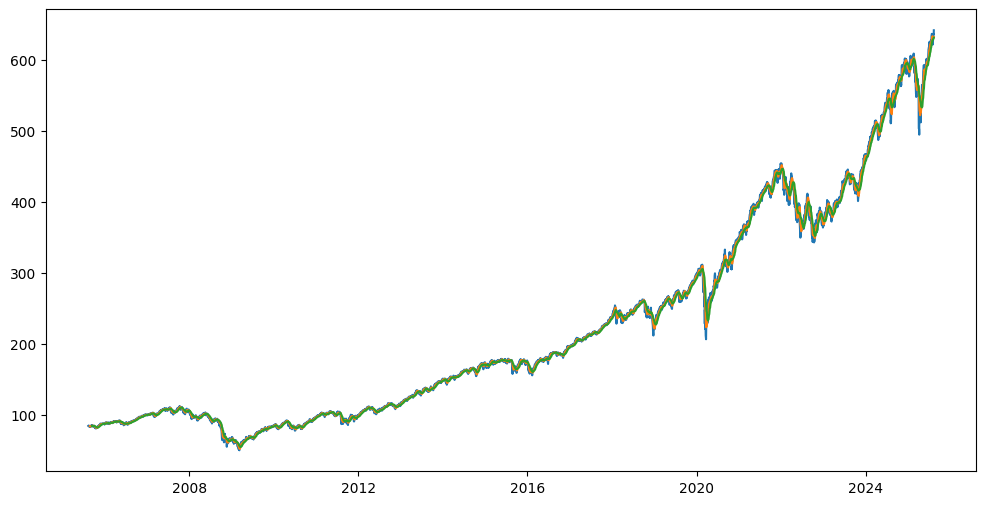

In [178]:
#Plot Chart 
plt.figure(figsize=(12, 6))
plt.plot(price.Close)
plt.plot(price.Fast_MA)
plt.plot(price.Slow_MA)
plt.show()

In [179]:
#Adding more flexibiltiy to the stop losses
atr_multiplier = 2
tp_ratio = 5


#Generating Trade Sginals 
#Long only
price['Signal'] = (price['Fast_MA'] > price['Slow_MA']) & (price['Fast_MA'].shift(1)< price['Slow_MA'].shift(1))
price['ATR'] = price.ta.atr(length=14)

#Slop Loss

price['SL'] = price['Open'] - price['ATR'].shift(1) * atr_multiplier
stop_size = price['Open'] - price['SL']
#Take Profit 1:1 ratio
price['TP'] = price['Open'] + (stop_size * tp_ratio)

price['Trade'] = price['Signal'].shift(1)
price['Trade'].iat[0] = False  # Set the first trade to False
#Only shows trades that were executed
price[price['Trade']]

,Close,High,Low,Open,Volume,Fast_MA,Slow_MA,Signal,ATR,SL,TP,Trade
Date,,,,,,,,,,,,
2005-11-01,83.212334,83.495489,83.025870,83.274492,66365100,82.365189,82.228383,False,0.989838,81.223127,93.531315,True
2006-01-06,89.172974,89.270172,88.423153,88.881378,62885900,87.748919,87.639617,False,0.741564,87.414483,96.215854,True
2006-02-21,89.207703,89.839487,89.068839,89.638151,46456300,88.596715,88.391410,False,0.830184,87.968624,97.985788,True
2006-03-17,91.047089,91.242258,90.879806,91.088909,47286800,89.802387,89.650673,False,0.764220,89.498658,99.040166,True
2006-04-26,90.893761,91.409573,90.824063,90.963469,67262400,90.845741,90.642486,False,0.796988,89.336958,99.096025,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-20,562.981018,564.031187,559.929560,562.574846,77503100,554.492954,550.901925,False,7.318464,547.443020,638.233978,True
2024-11-11,593.208130,594.605029,591.464439,594.248382,37586800,577.902439,576.931835,False,5.881585,582.063520,655.172691,True
2025-01-24,604.359863,607.153236,603.196828,606.188964,34604700,593.431885,590.283072,False,6.658987,592.455209,674.857738,True


In [180]:
#Defining starting variables 
balance = 1000
balance_history = []
trade_list = []
trade_open = False
risk_per_trade = 0.02
#iterate through data 
for i, row in price.iterrows():
    if not trade_open:
        #Generate trade
        if row.Trade == True:
            entry_date = i
            entry_price = row.Open
            sl = row.SL
            tp = row.TP
            #Calculate position size based on risk percentage
            risk_amount = balance * risk_per_trade
            position_size = risk_amount / (entry_price - sl)
            trade_open = True
    #Monitor Open Trade
    if trade_open == True:
        low = row.Low
        high = row.High

        #Check for stop loss 
        if low <= sl:
            if row.Open <= sl:
                exit_price = row.Open
            else:
                exit_price = sl
            trade_open = False
        #Check for TP
        if high >= tp:
            if row.Open >= tp:
                exit_price = row.Open
            else:
                exit_price = tp
            trade_open = False
        #process closed trade
        if not trade_open:
            exit_date = i 
            pnl = (exit_price - entry_price) * position_size
            balance += pnl
        
            #store trade in list
            trade = [entry_date, entry_price, exit_date, exit_price, position_size, pnl, balance]
            trade_list.append(trade)
    balance_history.append(balance)

    


In [181]:
trades = pd.DataFrame(trade_list, columns=["Entry Date", "Entry Price", "Exit Date", "Exit Price", "Position Size", "PnL", "Balance"])
trades


,Entry Date,Entry Price,Exit Date,Exit Price,Position Size,PnL,Balance
0,2005-11-01,83.274492,2006-09-26,93.531315,9.749608,100.000000,1100.000000
1,2007-01-18,101.237837,2007-02-27,99.697900,14.286290,-22.000000,1078.000000
2,2007-03-26,101.873592,2007-08-16,99.562573,9.329217,-21.560000,1056.440000
3,2007-08-30,103.703018,2008-01-09,99.642879,5.203959,-21.128800,1035.311200
4,2008-02-13,97.949633,2008-03-07,93.455806,4.652038,-20.905455,1014.405745
5,2008-03-31,95.018524,2008-07-07,90.612489,4.604620,-20.288115,994.117630
6,2008-07-29,90.176905,2008-09-16,85.245432,5.625528,-27.742141,966.375489
7,2008-11-07,67.047498,2008-11-20,58.397273,2.234336,-19.327510,947.047979
8,2008-12-09,66.111092,2009-02-05,58.365967,2.445533,-18.940960,928.107020
9,2009-02-10,63.624039,2009-02-17,59.047044,4.055530,-18.562140,909.544879


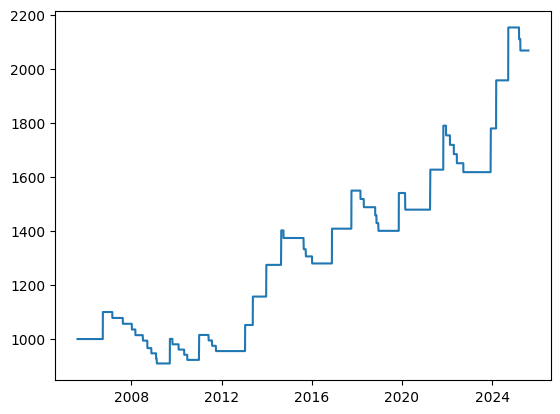

In [182]:
plt.plot(price.index, balance_history)
plt.show()